# Optimize any solution with group theory approach

Let's say you have a sequence of moves leading to a solution. Can we make this sequense shorter without changing the solution? Yes, we can! There are moves that cancel each other or can be written shorter. 

Note: this notebook mostly focuses on cubes. Add your suggestions for other puzzles in the comments!

## Cancelling moves
If you move the side and than move it backwards, it changes nothing. `'r1.-r1.r0'` is equivalent to just `'r0'`. This is true for any puzzle

## 4 repetitions of the same move for cubes
If you move the same face of the cube 4 times, you change nothing. So, `'r1.r1..r1.r1.r0'` is equivalent to `'r0'`.

## 3 repetitions of the same move for cubes is identical to 1 inverse move
We can make the sequence a bit shorter by substituting 3 moves of the same face to 1 inverse move. For example, `'r1.r1.r1.r0'` is the same as `'-r1.r0'`

There are move possible optimizations, but these are the most obvious. Let's discuss more in the comments!

# Commutating sequences trick

That's cool but what are the chances that we meet 4 copies of the same move in a row? As noted by @cl12102783 in [this notebook](https://www.kaggle.com/code/cl12102783/cancel-pairs-for-all-puzzles?scriptVersionId=158025216) and extended by @dinhttrandrise [here](https://www.kaggle.com/code/dinhttrandrise/added-cancel-opposite-pairs), we don't need to! Some moves *commute* meaning that it doesn't matter in which order you apply them. One obvious example, used in this notebook are moves of the same face. Each move does not affect axes of the other moves, they are "parallel". Think of 3x3 cube as an example: you can move the left and the right face in any order, the result won't change. So, `'r1.r0' == 'r0.r1'`. It is true for sequences of any length as far as they apply to the same face. `'r1.r0.r1.r1.r0.-r1' == 'r1.r1.r1.r0.r0.-r1'`.

Now optimizing sequences is much easier! We just need to find subsequences moving the same face, and apply optimizations described above to every one of them. Example of the algorithm:
1. Initial solution: `'r1.r0.r1.r1.-r0.r1.r1.f1.f0.-f1.r1.r0.r1.r1'`
2. Group subsequences moving the same faces: `['r1.r0.r1.r1.-r0.r1.r1', 'f1.f0.-f1', 'r1.r0.r1.r1']`
3. Optimize each subsequence applying transformations described above: `['r1', 'f0', '-r1.r0']`
    - From the first sequence we removed 4 copies of `'r1'` and cancelled `'r0'` and `'-r0'`
    - From the second sequence we removed cancelling pair `'f1'` and `'-f1'`
    - In the third sequence we substituted 3 copies of `'r1'` to `'-r1'`
4. Get optimized solution: `'r1.f0.-r1.r0'`

The result is the same, but the number of moves is significantly smaller! But can we find such sequences in sample submission or one of the public solutions? Let's explore

# Setup #

In [1]:
from collections import Counter
import itertools
from ast import literal_eval
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
from sympy.combinatorics import Permutation
import seaborn as sns
import matplotlib.pyplot as plt

Read the data from the competition and from @seanbearden 's [public solution](https://www.kaggle.com/code/seanbearden/solve-all-nxnxn-cubes-w-traditional-solution-state/notebook)

In [2]:
puzzle_info = pd.read_csv('puzzle_info.csv', index_col='puzzle_type')
# Parse allowed_moves
puzzle_info['allowed_moves'] = puzzle_info['allowed_moves'].apply(literal_eval)

puzzles = pd.read_csv('puzzles.csv', index_col='id')
# Parse color states
puzzles = puzzles.assign(
    initial_state=lambda df: df['initial_state'].str.split(';'),
    solution_state=lambda df: df['solution_state'].str.split(';')
)

submission = pd.read_csv('submission.csv', index_col='id')

You can see that in the solution of Sean moves are typically grouped by the same face. Maybe we can optimize it!

In [4]:
submission.loc[281, 'moves'][:500]

'f0.f1.f2.f3.f4.f5.f6.f7.f8.f9.f10.f11.f12.f13.f14.f15.d32.-r17.-r18.-r19.-r20.-r21.-r22.-r23.-r24.-r25.-r26.-r27.-r28.-r29.-r30.-r31.-r32.d17.d18.d19.d20.d21.d22.d23.d24.d25.d26.d27.d28.d29.d30.d31.d32.-f17.-f18.-f19.-f20.-f21.-f22.-f23.-f24.-f25.-f26.-f27.-f28.-f29.-f30.-f31.-f32.r0.r1.r2.r3.r4.r5.r6.r7.r8.r9.r10.r11.r12.r13.r14.r15.-d17.-d18.-d19.-d20.-d21.-d22.-d23.-d24.-d25.-d26.-d27.-d28.-d29.-d30.-d31.-d32.f0.f1.f2.f3.f4.f5.f6.f7.f8.f9.f10.f11.f12.f13.f14.f15.f0.f1.f2.f3.f4.f5.f6.f7.f8.f9.'

In [5]:
def apply_sequence(sequence, moves, state):
    """Apply a sequence of moves in array form to a color state."""
    state = np.asarray(state)
    for m in sequence.split('.'):
        state = state[moves[m]]
    return state


# Convert allowed_moves to dict and add inverse moves
all_moves = puzzle_info.loc[:, 'allowed_moves'].to_dict()
for ptype, moves in all_moves.copy().items():
    for m, arr in moves.copy().items():
        all_moves[ptype][f"-{m}"] = np.argsort(arr).tolist()

Let's take a look at one of the big cubes

In [6]:
puzzles[puzzles["puzzle_type"] == "cube_33/33/33"]

,puzzle_type,solution_state,initial_state,num_wildcards
id,,,,
281,cube_33/33/33,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...","[B, F, C, B, E, F, A, F, F, C, B, A, F, A, D, ...",0
282,cube_33/33/33,"[A, B, A, B, A, B, A, B, A, B, A, B, A, B, A, ...","[F, B, A, F, A, C, B, B, C, B, B, A, E, F, A, ...",0
283,cube_33/33/33,"[N0, N1, N2, N3, N4, N5, N6, N7, N8, N9, N10, ...","[N1056, N4357, N3264, N3270, N924, N2183, N109...",0


In [7]:
puzzle_idx = 281
puzzle_name = puzzles.loc[puzzle_idx, 'puzzle_type']
puzzle_name

'cube_33/33/33'

In [8]:
# Get info for the first puzzle
solution_state = puzzles.iloc[puzzle_idx, 1]
initial_state = puzzles.iloc[puzzle_idx, 2]
baseline_solution = submission.loc[puzzle_idx, 'moves']

Here's a bunch of helper code

In [9]:
def find_cube_inverse_move(move):
    if move[:2] == '--':
        return move
    elif move[0] == '-':
        return move [1:]
    else:
        return f'-{move}'

    
def is_same_group(move1, move2):
    """
    Check if two Rubik's cube moves belong to the same group (move the same side).

    Args:
        move1 (str): The first move.
        move2 (str): The second move.

    Returns:
        bool: True if moves belong to the same group, False otherwise.
    """
    return move1.lstrip('-')[0] == move2.lstrip('-')[0]


def group_cube_moves(moves):
    """
    Group Rubik's cube moves by side.

    Args:
        moves (list): A list of strings representing Rubik's cube moves.

    Returns:
        list: A list of lists, where each sublist contains consecutive moves of the same side.
    """
    grouped_moves = []
    current_group = []

    for move in moves:
        if not current_group or is_same_group(move, current_group[-1]):
            current_group.append(move)
        else:
            grouped_moves.append(current_group)
            current_group = [move]

    if current_group:
        grouped_moves.append(current_group)

    return grouped_moves

assert group_cube_moves(
    ['r1', 'r0', '-r1', '-r0', 'r0', 'f1', 'r0', '-f1', 'f1', 'f0']
) == [['r1', 'r0', '-r1', '-r0', 'r0'], ['f1'], ['r0'], ['-f1', 'f1', 'f0']]
assert group_cube_moves(['r1']) == [['r1']]
assert group_cube_moves(['r1', 'f1']) == [['r1'], ['f1']]
assert group_cube_moves(['r1', 'r0', 'f1']) == [['r1', 'r0'], ['f1']]


def remove_multiples_of_four(group):
    """
    Process a group of elements according to the specified algorithm.

    Args:
        group (list): A list of elements.

    Returns:
        list: A new list with elements repeated according to their modulo 4 count.
    """
    if len(group) < 4:
        return group
    
    # Step 1: Calculate the number of elements
    element_counts = Counter(group)

    # Step 2: Take modulo 4 for each count
    for element in element_counts:
        element_counts[element] %= 4

    # Step 3: Create a new list with the remaining counts
    new_group = []
    for element, count in element_counts.items():
        new_group.extend([element] * count)

    return new_group

assert sorted(remove_multiples_of_four(['r1', 'r1', 'r1', 'r1', 'r1', 'r0', 'r1'])) == ['r0', 'r1', 'r1']
assert remove_multiples_of_four(['r1', 'r1', 'r1', 'r1']) == []
assert remove_multiples_of_four(['r1', 'r1', 'r1']) == ['r1', 'r1', 'r1']
assert sorted(remove_multiples_of_four(['r1', 'r1', 'r1', 'r1', 'r1', 'r0', 'r1', 'r0', 'r0', 'r0'])) == ['r1', 'r1']
assert remove_multiples_of_four(['r1', 'r1', 'r1', 'r1', 'r0', 'r1', 'r1', 'r1', 'r1']) == ['r0']
assert sorted(remove_multiples_of_four(['r1', 'r1', 'r1', 'r1', 'r0', 'r1', 'r1', 'r1', 'r1', 'r1'])) == ['r0', 'r1']


def remove_cancelling_pairs(group):
    """
    Remove an element and its inverse from a group of Rubik's cube moves efficiently.

    Args:
        group (list): A list of strings representing a group of Rubik's cube moves.

    Returns:
        list: A list with paired elements and their inverses removed based on counts.
    """
    if len(group) < 2:
        return group
    
    move_counts = Counter(group)

    # Adjust counts for each move and its inverse
    for move, count in list(move_counts.items()):
        inv = find_cube_inverse_move(move)
        if inv in move_counts:
            min_count = min(move_counts[move], move_counts[inv])
            move_counts[move] -= min_count
            move_counts[inv] -= min_count

    # Construct the final list based on adjusted counts
    final_group = []
    for move, count in move_counts.items():
        final_group.extend([move] * count)

    return final_group

assert remove_cancelling_pairs(['r1', 'r0', '-r1']) == ['r0']
assert remove_cancelling_pairs(['-r1', 'r1', 'r1']) == ['r1']
assert remove_cancelling_pairs(['r1', 'r0', 'r1', '-r1', '-r1']) == ['r0']
assert remove_cancelling_pairs(['r1', 'r0', 'r1', '-r1', '-r1', '-r0']) == []
assert remove_cancelling_pairs(['r1', 'r0', 'r1', '-r1', '-r1', '-r0', 'r0']) == ['r0']
assert remove_cancelling_pairs(['r1']) == ['r1']
assert remove_cancelling_pairs(['r1', 'r1']) == ['r1', 'r1']


def substitute_three_for_inverse(group):
    """
    Substitute every three occurrences of an element with one occurrence of its inverse.

    Args:
        group (list): A list of strings representing a group of Rubik's cube moves.

    Returns:
        list: A list with every three occurrences of an element substituted with its inverse.
    """
    
    if len(group) < 3:
        return group

    move_counts = Counter(group)

    new_group = []
    for move, count in move_counts.items():
        inverse_count = count // 3
        remainder_count = count % 3
        new_group.extend([find_cube_inverse_move(move)] * inverse_count)
        new_group.extend([move] * remainder_count)

    return new_group

# Test cases
assert substitute_three_for_inverse(['r1', 'r1', 'r1']) == ['-r1']
assert sorted(substitute_three_for_inverse(['r1', 'r0', 'r1'])) == ['r0', 'r1', 'r1']
assert sorted(substitute_three_for_inverse(['r1', 'r0', 'r1', 'r1'])) == ['-r1', 'r0']
assert sorted(substitute_three_for_inverse(['r1', 'r0', 'r1', 'r1', 'r0', 'r0'])) == ['-r0', '-r1']
assert sorted(substitute_three_for_inverse(['r1', 'r0', 'r1', 'r1', 'r0', 'r0', 'r1'])) == ['-r0', '-r1', 'r1']
assert substitute_three_for_inverse(['r1']) == ['r1']
assert substitute_three_for_inverse(['r1', 'r1']) == ['r1', 'r1']

def groups_to_solution(groups: list):
    """Convert list of lists of moves to one list"""
    return list(itertools.chain.from_iterable(groups))


def regroup(groups):
    """Merge groups to a list of moves, then split to groups again to remove empty groups"""
    moves = groups_to_solution(groups)
    # print("Moves:", len(moves))
    return group_cube_moves(moves)


def optimize_solution(moves, puzzle="cube"):
    """Apply optimizations while length of moves is decreasing"""
    
    groups = group_cube_moves(moves)
    previous_length = len(moves)
    keep_optimizing = True
    
    while keep_optimizing:
        if puzzle == "cube":
            # First try to remove as many meaningless moves as possible
            # print("Removing 4s")
            groups = [remove_multiples_of_four(group) for group in groups]
            groups = regroup(groups)  # If some groups became empty, other groups can appear so we need to regroup
        
        if puzzle in ("cube", "wreath"):
            # Try to remove more elements by throwing out cancellations
            # print("Removing pairs")
            groups = [remove_cancelling_pairs(group) for group in groups]
            groups = regroup(groups)
        
        if puzzle == "cube":
            # Finally, try to reduce length a bit by substituting triplets. It will not require regrouping
            # print("Substituting triplets")
            groups = [substitute_three_for_inverse(group) for group in groups]
            moves = groups_to_solution(groups)

        keep_optimizing = (len(moves) != previous_length)
        previous_length = len(moves)
        # print("Moves:", len(moves))
        
    return moves

Let's take a look how big are the subsequences of the moves of the same face

In [10]:
solution = baseline_solution.split('.')
solution_groups = group_cube_moves(solution)
groups_lengths = [len(group) for group in solution_groups]

len(solution)

83567

Text(0.5, 1.0, 'Length of subsequences of the same face moves in the baseline solution')

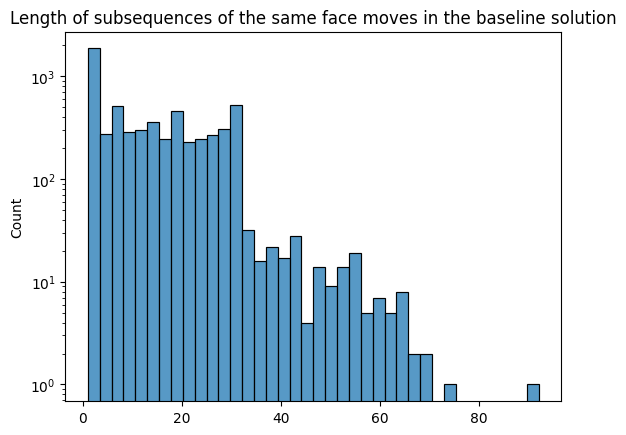

In [11]:
sns.histplot(groups_lengths)
plt.yscale('log')
plt.title('Length of subsequences of the same face moves in the baseline solution')

We can see that in the baseline submission, sequences of the moves of the same face are typically not very long. What about Sean's submission?

The solution is shorter, but there are much longer subsequences! If you think about it, they are absurdly long sometimes. You can move the same face by `33*2 = 66` different ways without cancellations or repetitions of the same move 3 times. All the longer sequences necessarily contain either cancellation of some move or triplets of the same move and therefore can be optimized.

Let's check how each of the optimizations impact the length of the solution:

In [13]:
filtered_groups = [remove_multiples_of_four(group) for group in solution_groups]
filtered_groups_lengths = [len(group) for group in filtered_groups]
print("Before:", sum(groups_lengths))
print("After:", sum(filtered_groups_lengths))

# Check if the state is a valid solution
filtered_solution = ".".join(groups_to_solution(filtered_groups))
state = apply_sequence(filtered_solution, all_moves[puzzle_name], initial_state)
np.array_equal(state, solution_state)

Before: 83567
After: 80939


True

In [14]:
filtered_groups = [remove_cancelling_pairs(group) for group in solution_groups]
filtered_groups_lengths = [len(group) for group in filtered_groups]
print("Before:", sum(groups_lengths))
print("After:", sum(filtered_groups_lengths))

filtered_solution = ".".join(groups_to_solution(filtered_groups))
state = apply_sequence(filtered_solution, all_moves[puzzle_name], initial_state)
np.array_equal(state, solution_state)

Before: 83567
After: 83409


True

In [15]:
filtered_groups = [substitute_three_for_inverse(group) for group in solution_groups]
print("Before:", sum(groups_lengths))
print("After:", sum([len(group) for group in filtered_groups]))

filtered_solution = ".".join(groups_to_solution(filtered_groups))
state = apply_sequence(filtered_solution, all_moves[puzzle_name], initial_state)
np.array_equal(state, solution_state)

Before: 83567
After: 82077


True

The solution is still correct, but we removed **thousands** of moves, including multiples of 4s! Now let's apply all these optimizations as many times as we can:

In [17]:
solutions = []
old_lengths = []
new_lengths = []

for puzzle_idx in range(puzzles.shape[0]):
    puzzle_name = puzzles.loc[puzzle_idx, 'puzzle_type']
    puzzle_type = puzzle_name[:puzzle_name.find("_")]
    
    sean_solution = submission.loc[puzzle_idx, 'moves']
    solution = sean_solution.split('.')
    new_solution = optimize_solution(solution, puzzle_type)

    solutions.append(new_solution)
    old_lengths.append(len(solution))
    new_lengths.append(len(new_solution))
    
    if len(solution) != len(new_solution):
        solution_state = puzzles.iloc[puzzle_idx, 1]
        initial_state = puzzles.iloc[puzzle_idx, 2]
        state = apply_sequence(".".join(new_solution), all_moves[puzzle_name], initial_state)
        print(puzzle_type, puzzle_idx, "Solution is correct:", np.array_equal(state, solution_state))
    
#    print(len(solution), len(new_solution))
#    print()

cube 121 Solution is correct: True
cube 151 Solution is correct: True
cube 153 Solution is correct: True
cube 155 Solution is correct: True
cube 156 Solution is correct: True
cube 160 Solution is correct: True
cube 162 Solution is correct: True
cube 167 Solution is correct: True
cube 168 Solution is correct: True
cube 171 Solution is correct: True
cube 172 Solution is correct: True
cube 173 Solution is correct: True
cube 174 Solution is correct: True
cube 175 Solution is correct: True
cube 176 Solution is correct: True
cube 177 Solution is correct: True
cube 178 Solution is correct: True
cube 179 Solution is correct: True
cube 182 Solution is correct: True
cube 183 Solution is correct: True
cube 184 Solution is correct: True
cube 185 Solution is correct: True
cube 188 Solution is correct: True
cube 192 Solution is correct: True
cube 194 Solution is correct: True
cube 196 Solution is correct: True
cube 197 Solution is correct: True
cube 198 Solution is correct: True
cube 199 Solution is

In [18]:
improvement = np.array(old_lengths) - np.array(new_lengths)

Text(0, 0.5, "Sean's optimized solution")

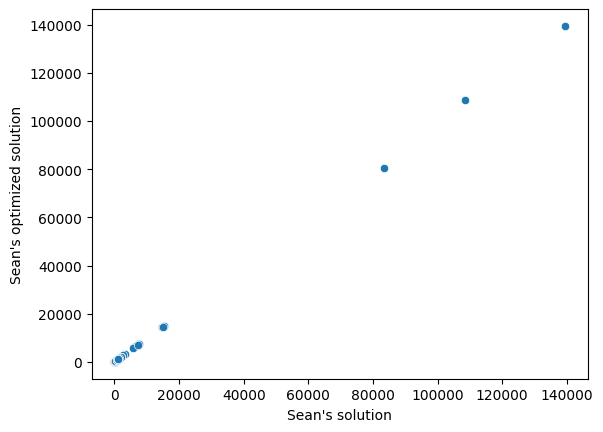

In [19]:
sns.scatterplot(x=old_lengths, y=new_lengths)
plt.xlabel("Sean's solution")
plt.ylabel("Sean's optimized solution")

In [20]:
sum(improvement)

6136

We won more than 9000 steps!

<Axes: ylabel='Count'>

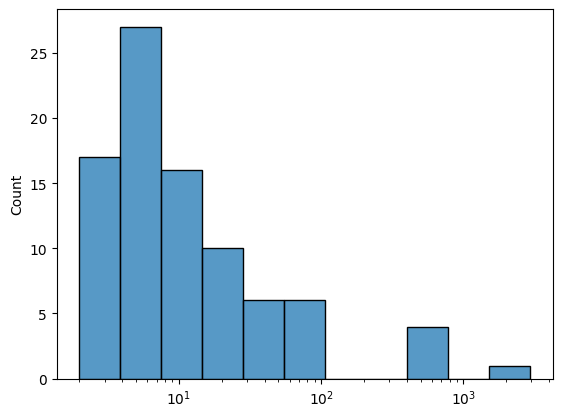

In [21]:
sns.histplot(improvement[improvement > 0], log_scale=(True, False))

In [23]:
moves = [".".join(moves) for moves in solutions]
my_submission = submission.copy()
my_submission["moves"] = moves

In [24]:
my_submission.to_csv("optimized_seans.csv")

You can apply the same procedure to any solution you have. Hopefully, you'll get great results! Share other ideas of improvements in comments. Obvious directions are:
- Extend optimizations to the other puzzles
- Find more complicated optimizations. The fact that you can sort the moves how you like inside subsequences might help